# TensorFlow Tutorials
# ML Basics 03 - Text Classification

## Setting Up Workspace

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
    %tensorflow_version 2.x
except Exception:
    pass

In [2]:
# Tensorflow and Keras API
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.13.1


## Loading Data
- IMDb dataset: 50k reviews (25k positive, 25k negative so balanced)
- Balanced binary classification problem: only two classes (1 - positive, 0 - negative) for reviews.
- Reviews have been preprocessed as sequences of integers. 

In [3]:
imdb = keras.datasets.imdb

In [5]:
# Configuring numpy to read from IMDb pickle file
import numpy as np
old = np.load
np.load = lambda *a,**k: old(*a, allow_pickle=True, **k)

In [6]:
# Tuple unpacking for train-test split: limiting reviews to 10k most commonly occurring words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## Exploring Data
Each review is an array or sequence of integers, where each integer is a way of encoding one of 10k commonly occurring words. 

Labels are 1 for positive reviews, and 0 for negative reviews.

In [8]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [9]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [11]:
# Not all reviews will have the same number of words
# NN inputs must have the same dimensions - will resolve with padding
print(len(train_data[0]), len(train_data[1]))

218 189


In [13]:
# Can convert the integers back to words using a dictionary lookup
word_index = imdb.get_word_index()

1646592/1641221 [==============================] - 5s 3us/step


In [15]:
# The first four indices are reserved - so shift all values will be shifted by 3
word_index = {k:(v+3) for k, v in word_index.items()}

# Inserting values for the four reserved keywords
word_index['<PAD>'] = 0
word_index['<START>'] = 1
word_index['<UNK>'] = 2     # Unknown
word_index['<UNUSED>'] = 3  

In [16]:
# Create a new dictionary from the word_index dictionary
# In which the key is the integer and the value is the word it encodes
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [19]:
# A function decode reviews
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [21]:
# Can now use this function to find the words for the first review
decode_review(train_data[0])

"<START> in with i like horrible business chinese charm would killer waited which explosion ? going at fun ? film make like lame character has novel <UNK> a all final sense ? real ? find character nothing <UNK> second perhaps they ? find valuable cover this city an br overall ? horror has i ? should shop was in with ? delightful 00 despite ? with their people is i like horrible an well it br garbage ? with this genre this is i taken that <UNK> ? she sex is and house and after ? ? product bud i final which returned be ? does is i an annoying ? film where if at man it's film sent be ? with is comedy you than some ? in perfect i get <UNK> and ? think plot windows it fun ? <UNK> the lou ? sequence at their like horrible wanted on getting night just the ? <UNK> rich br any other ? couple it someone then he decade more on why ? can't ajay that ? family with for still wanted on final ? such his lindsay that if at you interesting how film any ? family would i an g other is i once ? i boot seen

## Preparing Data
NN must receive inputs of the same, standardised dimensions/lengths. Because different reviews will have different number of words (and thus different lengths) we can either one-hot encode all reviews or pad them with blank characters so that they have the same length.

In [22]:
# Padding sequences so that they have the same length 
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value=word_index["<PAD>"], 
                                                       padding='post', 
                                                       maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data, 
                                                      value=word_index["<PAD>"], 
                                                      padding='post', 
                                                      maxlen=256)

## Building the Model

In [25]:
# input shape is the vocabulary count used for the movie
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Display basic details about the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


First layer is an `Embedding` layer. It will take a sequence of words representing a single review, and will encode each word in the review as a 16-dimensional vector.

Second layer is a `GlobalAveragePooling1D` layer. It reutrns a fixed-lenght output vector by averaging over the sequence dimension. This is the simplest way of allowing the model to handle input of variable length. 

Third and fourth layers are conventional densely connected ANN layers. The last layer has a single output node which outputs the probability of a specific review belonging to the positive class (y = 1).

In [26]:
model.compile(optimizer='adam', 
             loss='binary_crossentropy', 
             metrics=['accuracy'])

In [28]:
# Creating a validation set from the training set to monitor performance during training
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the Model

In [29]:
history = model.fit(partial_x_train, 
                   partial_y_train, 
                   epochs=40, 
                   batch_size=512, 
                   validation_data=(x_val, y_val), 
                   verbose=1)

Train on 15000 samples, validate on 10000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/40
15000/15000 [==============================] - 3s 170us/sample - loss: 0.6918 - acc: 0.5783 - val_loss: 0.6894 - val_acc: 0.6402
Epoch 2/40
15000/15000 [==============================] - 1s 93us/sample - loss: 0.6844 - acc: 0.7089 - val_loss: 0.6793 - val_acc: 0.7368
Epoch 3/40
15000/15000 [==============================] - 1s 91us/sample - loss: 0.6693 - acc: 0.7523 - val_loss: 0.6607 - val_acc: 0.7571
Epoch 4/40
15000/15000 [==============================] - 1s 89us/sample - loss: 0.6437 - acc: 0.7617 - val_loss: 0.6318 - val_acc: 0.7678
Epoch 5/40
15000/15000 [==============================] - 1s 89us/sample - loss: 0.6068 - acc: 0.7925 - val_loss: 0.5938 - val_acc: 0.7894
Epoch 6/40
15000/15000 [==============================] - 1s 93us/sample - loss: 0.5605 - acc: 0.8153 - val_loss: 0.5492 - val_acc: 0.8067
Epoch 7/40
15000/15000 [==============================] - 1s 93us/s

## Evaluating the Model
How well does the model perform on the test set?

In [30]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 53us/sample - loss: 0.3457 - acc: 0.8693
[0.3457086467790604, 0.86928]


Validation set gave accuracy of 88.11%, while the test set gives a lower accuracy of 86.93%. This means there may be a little overfitting in the model.

## Plotting Training Data

In [32]:
history_dict = history.history
history_dict.keys() # loss, acc, val_loss, val_acc

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [33]:
import matplotlib.pyplot as plt 
%matplotlib inline

In [35]:
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

In [36]:
epochs = range(1, len(acc) + 1)

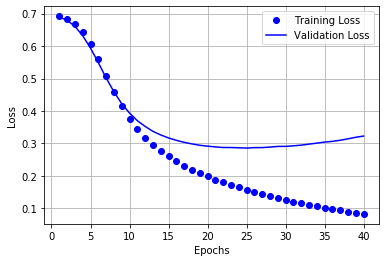

In [37]:
# Plotting training and validation loss
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

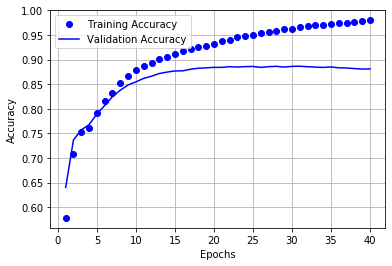

In [38]:
# Plotting training and validation accuracy
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()